In [1]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from Modules.simulation import Simulation
from Modules.cell_builder_reduced import SkeletonCell, InteractiveCellBuilder
from Modules.constants import HayParameters
from logger import Logger
import analysis

import os
from neuron import h

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import synapse


from Modules.morph_reduction_utils import get_reduced_cell

from spike_generator import PoissonTrainGenerator
from recorder import SegmentRecorder, SynapseRecorder

In [2]:
# Creates a standalone cell plot and colors synapses
def plot_segments(seg_data, elevation=0, azimuth=-100, radius_scale=1.0, synapse_counter = None, syn_color = 'red'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, seg in enumerate(seg_data):
        x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
        y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
        z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

        radius = seg.coords['r'].iloc[0] * radius_scale
        ax.plot(x_points, z_points, y_points, linewidth=radius, color = "black")

        if synapse_counter is not None:
            if seg.seg in synapse_counter:
                ax.scatter(x_points[1], z_points[1], y_points[1], color = syn_color, s = synapse_counter[seg.seg] / 100)

    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

# Plots the cell on a given axis and colors specified segments
def plot_segments_on_ax(seg_data, ax, elevation = 0, azimuth = -100, radius_scale = 1.0, color_segm = None):
    for _, seg in enumerate(seg_data):
        x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
        y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
        z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

        radius = seg.coords['r'].iloc[0] * radius_scale
        ax.plot(x_points, z_points, y_points, linewidth = radius, color = "black")

        if color_segm is not None:
            if seg.seg in color_segm.keys():
                ax.scatter(x_points[1], z_points[1], y_points[1], color = color_segm[seg.seg], s = 40)

    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

Init a simulation and parameters, compile the modfiles

In [3]:
sim = Simulation(SkeletonCell.Hay)
parameters = HayParameters(sim_name = 'test', h_tstop = 3000)

In [4]:
os.system(f"nrnivmodl {sim.cell_type.value['modfiles']} > /dev/null 2>&1")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

Build complex morphology

(2024-09-12 10:44:12.754024)-[PID: 99571]–[INFO]: Building SkeletonCell.Hay.
(2024-09-12 10:44:13.020700)-[PID: 99571]–[INFO]: Finished creating a CellModel object.
Removing duplicate coordinate at index 1 in section L5PCtemplate[0].apic[0]


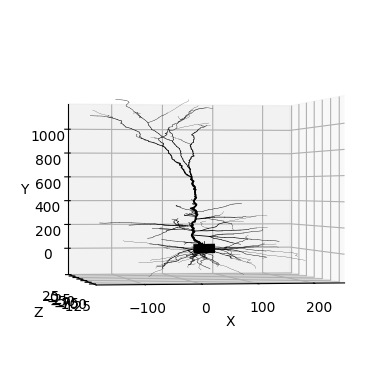

In [5]:
# Build the cell
logger = Logger(None)
cell_builder = InteractiveCellBuilder(sim.cell_type, parameters, logger)
cell, _ = cell_builder.build_complex_morphology()

plot_segments(cell.get_segments(["all"])[1])

Reduce the cell

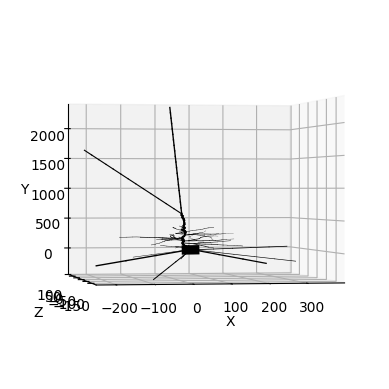

In [6]:
cell, original_seg_data, all_deleted_seg_indices = get_reduced_cell(
    reduce_tufts = True, 
    reduce_basals = True,
    reduce_obliques = False, 
    reduce_apic = False,
    cell = cell)

plot_segments(cell.get_segments(["all"])[1])

Check dimensions

In [7]:
perisomatic = []
apic = []
dend = []

segments, datas = cell.get_segments(['all'])

for segid, data in enumerate(datas):
    if h.distance(segments[segid], cell.soma[0](0.5)) < 100:
        perisomatic.append(data.L)
        continue
    elif "apic" in data.section:
        apic.append(data.L)
    elif "dend" in data.section:
        dend.append(data.L)

# Check
print(len(cell.get_segments(['all'])[1]), "==", len(perisomatic) + len(dend) + len(apic))

# Print lengths
print("Perisomatic:", np.sum(perisomatic))
print("Apical:", np.sum(apic))
print("Basal:", np.sum(dend))

261 == 261
Perisomatic: 1016.1111449698909
Apical: 6539.561489325351
Basal: 1488.9949469424716


Check passive FI curve

In [8]:
# amps = [0, 0.5, 1, 1.5]
# FR = []

# for amp in amps:
#     cell.set_injection(amp = amp, dur = 2900, delay = 10, target = 'soma')
#     cell.add_spike_recorder(sec = cell.soma[0], var_name = "soma_spikes", spike_threshold = parameters.spike_threshold)
#     sim.set_neuron_parameters(parameters)
#     h.run()

#     soma_spikes = cell.recorders[0].vec.as_numpy().reshape(1, -1)
#     print(soma_spikes)
#     FR.append(soma_spikes.shape[1] * 1000 / parameters.h_tstop)

#     cell.recorders = []
#     cell.current_injection = None

In [9]:
# FR

[0.0, 8.333333333333334, 15.333333333333334, 19.0]

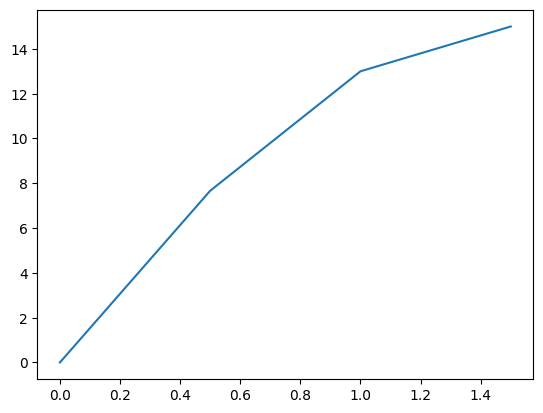

In [11]:
# plt.plot(amps, FR)

#### Check EPSC

In [8]:
def lognormal_to_underlying_normal(mu_logn, sigma_logn):
    mu = np.log(mu_logn ** 2 / np.sqrt(mu_logn ** 2 + sigma_logn ** 2))
    sigma = np.sqrt(np.log(1 + (sigma_logn ** 2) / (mu_logn ** 2)))
    return mu, sigma

In [9]:
def compute_PSC(
        gmax: float,
        gmax_lognormal_mean: float,
        gmax_lognormal_std: float,
        syn_mod: str,
		syn_params: list,
        release_prob_mean: float,
        release_prob_std: float,
        seg_name: str,
        min_distance_from_soma: float,
        max_distance_from_soma: float,
        n_simulations: int = 100
        ) -> None:
    
    magnitudes = []
    synapse_random_state = np.random.RandomState(431)

    for i in range(n_simulations):

        parameters.h_tstop = 500

        if gmax is None:
            gmax = np.abs(cell.random_state.lognormal(*lognormal_to_underlying_normal(gmax_lognormal_mean, gmax_lognormal_std)))

        # Pick the index of a random segment
        random_segment_id = synapse_random_state.randint(0, len(cell.get_segments([seg_name])))

        # Check distance conditions
        while ((h.distance(cell.get_segments([seg_name])[0][random_segment_id], cell.soma[0](0.5)) < min_distance_from_soma) and 
               (h.distance(cell.get_segments([seg_name])[0][random_segment_id], cell.soma[0](0.5)) > max_distance_from_soma)):
            random_segment_id = synapse_random_state.randint(0, len(cell.get_segments([seg_name]))) 

        # Add one synapse
        cell.add_synapses_over_segment(
                cell.get_segments([seg_name])[0][random_segment_id],
                1,
                syn_mod,
                cell.random_state.choice(syn_params),
                gmax,
                "dummy",
                np.abs(cell.random_state.normal(release_prob_mean, release_prob_std)))

        # Set the spike train
        spike_train = [100, 200, 300]
        vec = h.Vector(spike_train)
        stim = h.VecStim()
        stim.play(vec)
        cell.synapses[0].netcons.append(h.NetCon(stim, cell.synapses[-1].h_syn, 1, 0, 1))

        # Set the synaptic current recorder
        cell.recorders.append(SynapseRecorder(cell.synapses[-1].h_syn, "i"))

        # Run the simulation
        sim.set_neuron_parameters(parameters)
        h.run()

        i = cell.recorders[-1].vec.as_numpy()
        magnitudes.append((np.max(i) - np.min(i)) * 1000)

        # Clear recorders and synapses
        cell.recorders = []
        cell.synapses = []

    print(f"Magnitude: {np.mean(magnitudes)} pA +- {np.std(magnitudes)}")

In [13]:
# # Basal
# compute_PSC(
#     gmax = None,
#     gmax_lognormal_mean = 0.8,
#     gmax_lognormal_std = 0.8,
#     syn_mod = "AMPA_NMDA_STP",
#     syn_params = [synapse.CP2CP_syn_params, synapse.CS2CP_syn_params],
#     release_prob_mean = 0.53,
#     release_prob_std = 0.22,
#     seg_name = "dend",
#     min_distance_from_soma = 100,
#     max_distance_from_soma = 1e15,
# )

Magnitude: 30.11275236923453 pA +- 25.32982743403574


In [14]:
# # Apical
# compute_PSC(
#     gmax = None,
#     gmax_lognormal_mean = 0.6,
#     gmax_lognormal_std = 0.545,
#     syn_mod = "AMPA_NMDA_STP",
#     syn_params = [synapse.CP2CP_syn_params, synapse.CS2CP_syn_params],
#     release_prob_mean = 0.53,
#     release_prob_std = 0.22,
#     seg_name = "apic",
#     min_distance_from_soma = 100,
#     max_distance_from_soma = 1e15,
# )

Magnitude: 27.712094520876743 pA +- 26.442435124730874


#### Place excitatory synapses

In [9]:
synapse_counter = {}

In [10]:
# Basal
segments, datas = cell.get_segments(['dend'])
local_counter = []

for seg, seg_info in zip(segments, datas):
    # Don't include perisomatic
    if h.distance(seg, cell.soma[0](0.5)) < 100: continue

    nsyn = int(seg_info.L * np.abs(cell.random_state.normal(2.8, 0.16)))
    local_counter.append(nsyn)
    synapse_counter[seg.__repr__()] = nsyn

    gmax = np.abs(cell.random_state.lognormal(*lognormal_to_underlying_normal(0.8, 0.8)))
    
    cell.add_synapses_over_segment(
			seg,
			nsyn,
			"AMPA_NMDA_STP", 
            cell.random_state.choice([synapse.CS2CP_syn_params, synapse.CP2CP_syn_params]),
			gmax,
			"basal-exc",
			np.abs(cell.random_state.normal(0.53, 0.22)))

In [11]:
print(f"Num (basal): {np.sum(local_counter)}")

Num (basal): 4227


In [12]:
# Apical
segments, datas = cell.get_segments(['apic'])
local_counter = []

for seg, seg_info in zip(segments, datas):

    if h.distance(seg, cell.soma[0](0.5)) < 100: continue

    nsyn = int(seg_info.L * np.abs(cell.random_state.normal(2.16, 0.16)))
    local_counter.append(nsyn)
    synapse_counter[seg.__repr__()] = nsyn

    gmax = np.abs(cell.random_state.lognormal(*lognormal_to_underlying_normal(0.6, 0.545)))
    
    cell.add_synapses_over_segment(
			seg,
			nsyn,
			"AMPA_NMDA_STP", 
            cell.random_state.choice([synapse.CS2CP_syn_params, synapse.CP2CP_syn_params]),
			gmax,
			"apic-exc",
			np.abs(cell.random_state.normal(0.53, 0.22)))

In [13]:
print(f"Num (apical): {np.sum(local_counter)}")

Num (apical): 14121


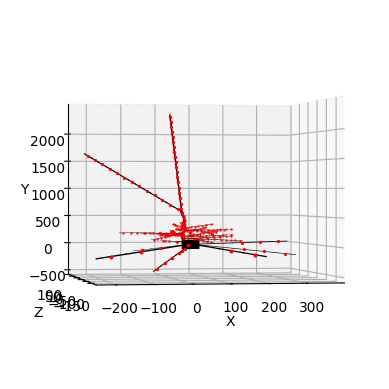

In [14]:
plot_segments(cell.get_segments(["all"])[1], synapse_counter = synapse_counter)

#### Check IPSC

In [17]:
# # Perisomatic
# compute_PSC(
#     gmax = 36,
#     gmax_lognormal_mean = None,
#     gmax_lognormal_std = None,
#     syn_mod = "GABA_AB_STP",
#     syn_params = [synapse.FSI_syn_params, synapse.LTS_syn_params],
#     release_prob_mean = 0.88,
#     release_prob_std = 0.05,
#     seg_name = "all",
#     min_distance_from_soma = 0,
#     max_distance_from_soma = 100,
# )

Magnitude: 145.4879220067156 pA +- 24.025307492678873


In [10]:
# # Basal
# compute_PSC(
#     gmax = 6,
#     gmax_lognormal_mean = None,
#     gmax_lognormal_std = None,
#     syn_mod = "GABA_AB_STP",
#     syn_params = [synapse.FSI_syn_params, synapse.LTS_syn_params],
#     release_prob_mean = 0.72,
#     release_prob_std = 0.1,
#     seg_name = "dend",
#     min_distance_from_soma = 100,
#     max_distance_from_soma = 1e15,
# )

Magnitude: 21.203237567899535 pA +- 3.262953568951449


In [11]:
# # Apical
# compute_PSC(
#     gmax = 6,
#     gmax_lognormal_mean = None,
#     gmax_lognormal_std = None,
#     syn_mod = "GABA_AB_STP",
#     syn_params = [synapse.FSI_syn_params, synapse.LTS_syn_params],
#     release_prob_mean = 0.3,
#     release_prob_std = 0.08,
#     seg_name = "apic",
#     min_distance_from_soma = 100,
#     max_distance_from_soma = 1e15,
# )

Magnitude: 26.273313315152876 pA +- 4.3234354891176645


In [8]:
# from recorder import SynapseRecorder

# # apic[1] --> 3
# # dend[84] --> 0

# # Perisomatic: apic[0] -> 0

# magnitudes = []

# for i in range(30):

#         parameters.h_tstop = 800

#         cell.add_synapses_over_segment(
#                 cell.get_segments(['apic'])[0][0],
#                 1,
#                 "GABA_AB_STP",
#                 cell.random_state.choice([synapse.FSI_syn_params, synapse.LTS_syn_params]),
#                 15,
#                 "inh",
#                 np.abs(cell.random_state.normal(0.88, 0.05)))

#         spike_train = [100, 200, 300]
#         vec = h.Vector(spike_train)
#         stim = h.VecStim()
#         stim.play(vec)
#         cell.synapses[0].netcons.append(h.NetCon(stim, cell.synapses[-1].h_syn, 1, 0, 1))

#         cell.recorders.append(SynapseRecorder(cell.synapses[-1].h_syn, "i"))

#         sim.set_neuron_parameters(parameters)
#         h.run()

#         i = cell.recorders[-1].vec.as_numpy()
#         magnitudes.append((np.max(i) - np.min(i)) * 1000)

#         cell.recorders = []
#         cell.synapses = []

# print(f"Magnitude: {np.mean(magnitudes)} pA +- {np.std(magnitudes)}")

Magnitude: 62.58296843359479 pA +- 10.493596758848048


#### Place inhibitory synapses

In [15]:
synapse_counter = {}

In [16]:
# Soma
segments, datas = cell.get_segments(['soma'])

for seg, seg_info in zip(segments, datas):
    soma_nsyn = 50
    synapse_counter[seg.__repr__()] = soma_nsyn
    cell.add_synapses_over_segment(
			seg,
			soma_nsyn,
			"GABA_AB_STP",
            cell.random_state.choice([synapse.FSI_syn_params, synapse.LTS_syn_params]),
			36,
			"soma-inh",
			np.abs(cell.random_state.normal(0.88, 0.05)))

In [17]:
# Perisomatic
segments, datas = cell.get_segments(['all'])
local_counter = []

for seg, seg_info in zip(segments[1:], datas[1:]):
    if h.distance(seg, cell.soma[0](0.5)) < 100:
        nsyn = int(seg_info.L * np.abs(cell.random_state.normal(0.13, 0.02)))
        local_counter.append(nsyn)
        synapse_counter[seg.__repr__()] = nsyn
        
        cell.add_synapses_over_segment(
                seg,
                nsyn,
                "GABA_AB_STP",
                cell.random_state.choice([synapse.FSI_syn_params, synapse.LTS_syn_params]),
                36,
                "perisomatic-inh",
                np.abs(cell.random_state.normal(0.88, 0.05)))

In [18]:
print(f"Num (soma + perisomatic): {soma_nsyn + np.sum(local_counter)}")

Num (soma + perisomatic): 172


In [19]:
# Basal
segments, datas = cell.get_segments(['dend'])
local_counter = []

for seg, seg_info in zip(segments, datas):
    # Skip perisomatic
    if seg.__repr__() in synapse_counter: continue

    nsyn = int(seg_info.L * np.abs(cell.random_state.normal(0.03, 0.02)))
    local_counter.append(nsyn)
    synapse_counter[seg.__repr__()] = nsyn
    
    cell.add_synapses_over_segment(
			seg,
			nsyn,
			"GABA_AB_STP",
            cell.random_state.choice([synapse.FSI_syn_params, synapse.LTS_syn_params]),
			6,
			"basal-inh",
			np.abs(cell.random_state.normal(0.72, 0.1)))

In [20]:
print(f"Num (basal): {np.sum(local_counter)}")

Num (basal): 33


In [21]:
# Apical
segments, datas = cell.get_segments(['apic'])
local_counter = []

for seg, seg_info in zip(segments, datas):
    # Skip perisomatic
    if seg.__repr__() in synapse_counter: continue

    nsyn = int(seg_info.L * np.abs(cell.random_state.normal(0.32, 0.02)))
    local_counter.append(nsyn)
    synapse_counter[seg.__repr__()] = nsyn
    
    cell.add_synapses_over_segment(
			seg,
			nsyn,
			"GABA_AB_STP",
            cell.random_state.choice([synapse.FSI_syn_params, synapse.LTS_syn_params]),
			6,
			"apic-inh",
			np.abs(cell.random_state.normal(0.3, 0.08)))

In [22]:
print(f"Num (apic): {np.sum(local_counter)}")

Num (apic): 1995


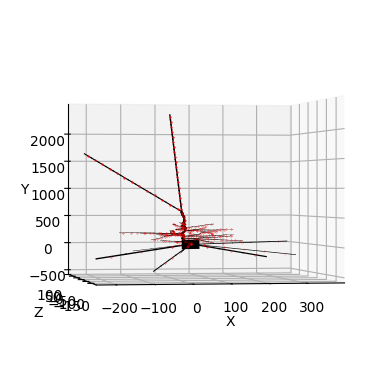

In [23]:
plot_segments(cell.get_segments(["all"])[1], synapse_counter = synapse_counter)

#### Assign excitatory spike trains

In [24]:
exc_fr = []

In [25]:
nsyn = len(cell.get_synapses(["basal-exc"]))
divergence = 5

for group in np.array_split(cell.get_synapses(["basal-exc"]), nsyn / divergence):
    firing_rates = np.abs(np.random.normal(4.43, 2.9, parameters.h_tstop))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = firing_rates, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)
    exc_fr.append(firing_rates)

In [26]:
nsyn = len(cell.get_synapses(["apic-exc"]))
divergence = 5

for group in np.array_split(cell.get_synapses(["apic-exc"]), nsyn / divergence):
    firing_rates = np.abs(np.random.normal(4.43, 2.9, parameters.h_tstop))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = firing_rates, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)
    exc_fr.append(firing_rates)

#### Assign inhibitory spike trains

In [27]:
inh_fr = np.roll(np.vstack(exc_fr).mean(axis = 1), 4)

In [28]:
# https://math.stackexchange.com/questions/2864140/can-i-increase-the-standard-deviation-of-a-series-without-increasing-its-mean

def modulate_to_mean_and_std(x, mu, sigma):
    # Shift to the desired mean
    x = x + (mu - np.mean(x))
    # Change std without affecting the mean
    x = (sigma / np.std(x)) * (x - np.mean(x)) + np.mean(x)
    return x

In [29]:
nsyn = len(cell.get_synapses(["soma-inh"]))
divergence = 2.8

for group in np.array_split(cell.get_synapses(["soma-inh"]), nsyn / divergence):
    firing_rates = np.abs(modulate_to_mean_and_std(inh_fr, 16.9, 14.3))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = inh_fr, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)

In [30]:
nsyn = len(cell.get_synapses(["perisomatic-inh"]))
divergence = 2.8

for group in np.array_split(cell.get_synapses(["perisomatic-inh"]), nsyn / divergence):
    firing_rates = np.abs(modulate_to_mean_and_std(inh_fr, 16.9, 14.3))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = firing_rates, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)

In [31]:
nsyn = len(cell.get_synapses(["basal-inh"]))
divergence = 2.7

for group in np.array_split(cell.get_synapses(["basal-inh"]), nsyn / divergence):
    firing_rates = np.abs(modulate_to_mean_and_std(inh_fr, 3.9, 4.9))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = firing_rates, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)

In [32]:
nsyn = len(cell.get_synapses(["apic-inh"]))
divergence = 12

for group in np.array_split(cell.get_synapses(["apic-inh"]), nsyn / divergence):
    firing_rates = np.abs(modulate_to_mean_and_std(inh_fr, 3.9, 4.9))
    spike_train = PoissonTrainGenerator.generate_spike_train(lambdas = firing_rates, random_state = cell.random_state)
    for synapse in group:
        synapse.set_spike_train(spike_train.spike_times)

[[ 835.7 1172.2 1201.1 1540.6 1682.3 1870.9 1920.7 1972.9 2014.  2272.8
  2393.3 2410.  2882.3 2891.5 2935.2 2996.1]]
5.333333333333333


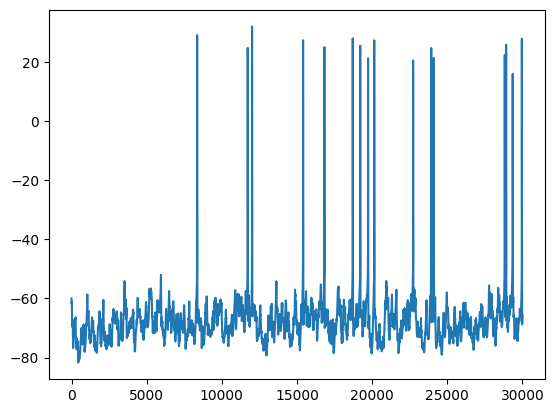

In [ ]:
# cell.recorders = []

# cell.add_spike_recorder(sec = cell.soma[0], var_name = "soma_spikes", spike_threshold = parameters.spike_threshold)
# cell.recorders.append(SegmentRecorder(cell.soma[0](0.5), "v"))
# sim.set_neuron_parameters(parameters)
# h.run()
# soma_spikes = cell.recorders[0].vec.as_numpy().reshape(1, -1)
# print(soma_spikes)

# print(soma_spikes.shape[1] * 1000 / parameters.h_tstop)

# plt.plot(cell.recorders[1].vec.as_numpy().reshape(-1, 1))

Check the control FI curve

In [33]:
# amps = [0, 0.5, 1, 1.5]
# FR = []

# for amp in amps:
#     cell.set_injection(amp = amp, dur = 2900, delay = 10, target = 'soma')
#     cell.add_spike_recorder(sec = cell.soma[0], var_name = "soma_spikes", spike_threshold = parameters.spike_threshold)
#     sim.set_neuron_parameters(parameters)
#     h.run()

#     soma_spikes = cell.recorders[0].vec.as_numpy().reshape(1, -1)
#     print(soma_spikes)
#     FR.append(soma_spikes.shape[1] * 1000 / parameters.h_tstop)

#     cell.recorders = []
#     cell.current_injection = None

[[ 517.7  828.7  937.2 1117.3 1235.1 1391.1 1605.6 1652.5 1667.6 1924.5
  2357.5 2456.  2638.9 2762.4 2904.8 2914.7]]
[[ 312.3  327.3  435.6  516.   565.9  575.   826.8  893.3  935.   942.5
  1079.8 1117.  1234.4 1378.6 1511.  1541.4 1605.2 1652.2 1913.7 1923.5
  2263.8 2355.8 2362.3 2453.2 2459.9 2637.3 2719.4 2762.  2899.7 2906.6
  2918.8]]
[[  36.9  279.2  289.9  309.4  324.   345.5  413.6  434.8  515.4  562.9
   574.6  825.5  831.4  892.9  934.3  942.  1078.3 1116.4 1233.4 1376.2
  1385.8 1509.7 1540.4 1604.4 1613.2 1654.6 1906.2 1916.4 1925.  2258.5
  2269.3 2353.4 2359.7 2449.5 2457.7 2549.2 2636.6 2718.7 2761.1 2853.8
  2899.7 2906.7]]
[[  15.2   23.2   35.4  205.3  273.4  280.2  288.9  308.6  323.5  345.7
   413.4  435.1  515.3  562.7  575.2  673.1  825.   830.8  892.5  932.1
   940.4 1075.1 1115.4 1123.8 1233.2 1368.9 1377.8 1389.9 1509.1 1540.
  1603.7 1612.4 1654.1 1904.8 1913.7 1922.6 2108.  2257.2 2265.7 2352.
  2358.  2394.1 2448.8 2457.6 2548.5 2616.3 2637.8 2718.8 2761.

In [34]:
# FR

[5.333333333333333, 10.333333333333334, 14.0, 17.333333333333332]

Check voltages at different segments

In [33]:
cell.recorders = []

cell.add_spike_recorder(sec = cell.soma[0], var_name = "soma_spikes", spike_threshold = parameters.spike_threshold)
cell.add_segment_recorders("v")

sim.set_neuron_parameters(parameters)
h.run()

0.0

In [34]:
soma_spikes = cell.recorders[0].vec.as_numpy().reshape(1, -1)
print(soma_spikes.shape[1] * 1000 / parameters.h_tstop)

5.333333333333333


In [35]:
# Collect voltage
v = cell.recorders[1].get_combined_data()

# Get segment names
seg_names = [seg.seg for seg in cell.get_segments(['all'])[1]]

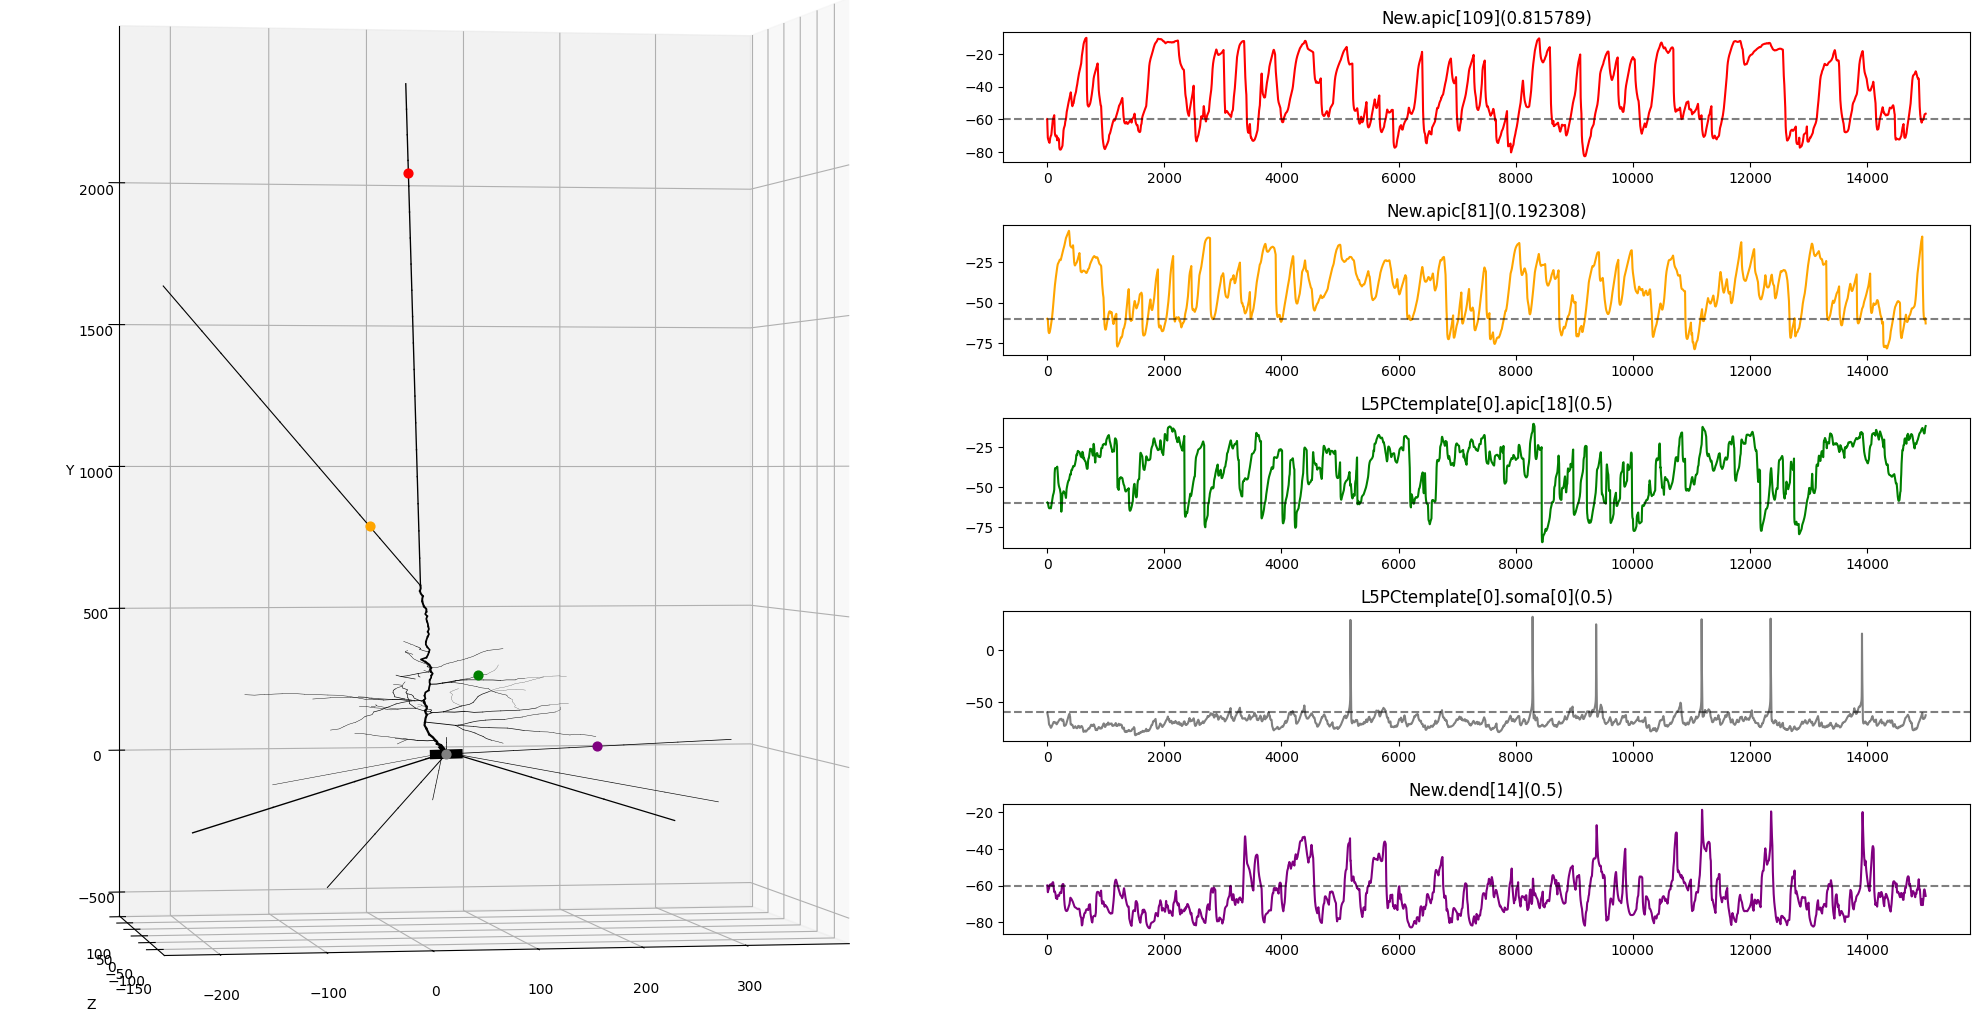

In [36]:
color_segm = {
    'New.apic[109](0.815789)': "red",
    'New.apic[81](0.192308)': "orange",
    'L5PCtemplate[0].apic[18](0.5)': "green",
    'L5PCtemplate[0].soma[0](0.5)': "gray",
    'New.dend[14](0.5)': "purple",
}

fig = plt.figure(figsize = (20, 10), constrained_layout = True)
axs = fig.subplot_mosaic([['11', '21'],
                          ['11', '22'],
                          ['11', '23'],
                          ['11', '24'],
                          ['11', '25']],
                          per_subplot_kw = {'11': {"projection": "3d"}})

# Plot the cell
plot_segments_on_ax(cell.get_segments(['all'])[1], axs['11'], color_segm = color_segm)
axs['11'].set_box_aspect(aspect=(1.6, 1, 2.2), zoom=1.3)

# Plot voltages
for axid in range(1, 6):
    seg_name = list(color_segm.keys())[axid - 1]
    axs[f'2{axid}'].plot(v[seg_names.index(seg_name)][:15000], color = color_segm[seg_name])
    axs[f'2{axid}'].set_title(seg_name)
    axs[f'2{axid}'].axhline(-60, c = 'black', linestyle = '--', alpha = 0.5)

Check dendritic properties

In [33]:
os.mkdir(sim.path)
parameters.path = os.path.join(sim.path, parameters.sim_name)

In [34]:
sim.set_all_recorders(cell, parameters)

In [35]:
# Classify segments by morphology, save coordinates
segments, seg_data = cell.get_segments(["all"]) # (segments is returned here to preserve NEURON references)
seg_sections = []
seg_idx = []
seg_coords = []
seg_half_seg_RAs = []
seg = []
seg_Ls = []
sec_Ls = []
sec_Ds = []
seg_distance = []
psegs=[]

for i,entry in enumerate(seg_data):
    # if parameters.build_stylized: #@DEPRACATED
    #     sec_name = entry.section.split(".")[-1]
    # else:
    sec_name = entry.section.split(".")[-1] # name[idx]
    #print(f"sec_name: {sec_name}")
    seg_sections.append(sec_name.split("[")[0])
    seg_idx.append(sec_name.split("[")[1].split("]")[0])
    seg_coords.append(entry.coords)
    seg_half_seg_RAs.append(entry.seg_half_seg_RA)
    seg.append(entry.seg)
    seg_Ls.append(entry.L)
    psegs.append(entry.pseg)
    sec_Ls.append(segments[i].sec.L)
    sec_Ds.append(segments[i].sec.diam)
    seg_distance.append(h.distance(segments[0], segments[i]))
    
    
seg_sections = pd.DataFrame({
    "section": seg_sections, 
    "idx_in_section_type": seg_idx,
    "seg_half_seg_RA": seg_half_seg_RAs,
    "L": seg_Ls,
    "seg":seg,
    "pseg":psegs,
    "Section_L":sec_Ls,
    "Section_diam":sec_Ds,
    "Distance":seg_distance
    })

seg_coords = pd.concat(seg_coords)

seg_data = pd.concat((seg_sections.reset_index(drop = True), seg_coords.reset_index(drop = True)), axis = 1)

In [36]:
sim.simulate(cell, parameters)

(2024-09-12 10:48:25.289322)-[PID: 99571]–[INFO]: Starting simulation.
(2024-09-12 10:49:02.753710)-[PID: 99571]–[INFO]: Saving data at step: 10000
(2024-09-12 10:49:04.647357)-[PID: 99571]–[INFO]: Finished writing data
(2024-09-12 10:49:04.695339)-[PID: 99571]–[INFO]: Finished clearing recorders
(2024-09-12 10:49:43.878433)-[PID: 99571]–[INFO]: Saving data at step: 20000
(2024-09-12 10:49:45.873676)-[PID: 99571]–[INFO]: Finished writing data
(2024-09-12 10:49:45.923246)-[PID: 99571]–[INFO]: Finished clearing recorders
(2024-09-12 10:50:22.116500)-[PID: 99571]–[INFO]: Saving data at step: 30000
(2024-09-12 10:50:23.735587)-[PID: 99571]–[INFO]: Finished writing data
(2024-09-12 10:50:23.783300)-[PID: 99571]–[INFO]: Finished clearing recorders
(2024-09-12 10:50:23.819538)-[PID: 99571]–[INFO]: Finish simulation in 118.528 seconds


In [37]:
seg_data.to_csv(os.path.join(parameters.path, "segment_data.csv"))

In [38]:
elec_distances_soma = cell.compute_electrotonic_distance(from_segment = cell.soma[0](0.5))
elec_distances_soma.to_csv(os.path.join(parameters.path, "elec_distance_soma.csv"))

In [39]:
import pickle
with open(os.path.join(parameters.path, "parameters.pickle"), "wb") as file:
    pickle.dump(parameters, file)

In [40]:
import analysis
soma_spikes = analysis.DataReader.read_data(parameters.path, "soma_spikes")
soma_spikes.shape[1] * 1000 / parameters.h_tstop

5.333333333333333

In [ ]:
# FI curve with synapses on
# I # Fr
# 0.5 # 11.0
# 1 # 15.0
# 1.5 # 16.33

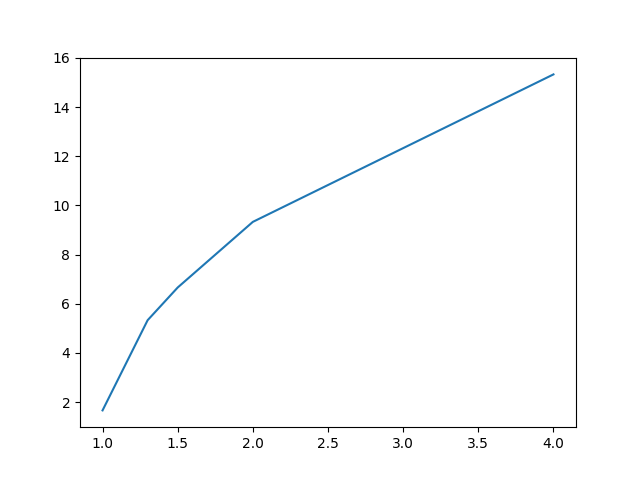

In [20]:
# exc scalar # FR
# 4 # 15.33
# 2 # 9.33
# 1.5 # 6.66
# 1.3 # 5.33
# 1.2 # 5.66
# 1.1 # 4
# 1.09 # 4.33
# 1.08 # 3.33
# 1 # 1.66

fig = plt.figure()
plt.plot([1, 1.3, 1.5, 2, 4], [1.66, 5.33, 6.66, 9.33, 15.33])

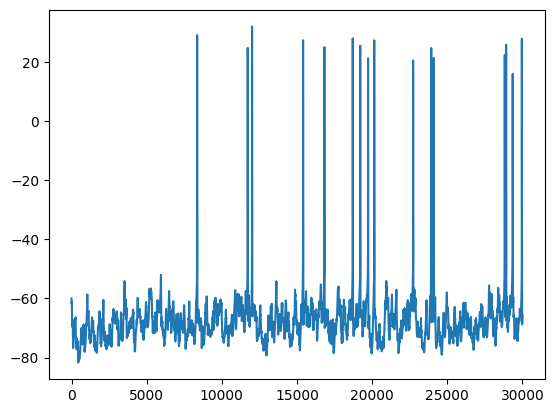

In [45]:
v = analysis.DataReader.read_data(parameters.path, "v")
fig = plt.figure()
plt.plot(v[0])
plt.show()

In [ ]:
v[0]

array([-77.2       , -77.22482298, -77.25188578, ..., -61.09507385,
       -61.05940069, -61.02302516])

Some Notes: 
Compare detailed and reduced
Try allen database cell
1. We adapted neuron_reduce for more user-control.
2. Currently not Mapping synapses, but it will be easy to add.
3. We could convert single-cylinders into an equivalent set of nbranches.